Bug: SVD will not converge error when finding amplitudes for large rank.

Cause: whitespace is embedding to zero vector, causing rank reduction and zero singular/eigenvalues, e.g. setting t=500 is too small, because with embedding dim. = 300 the rank drops to 196.

Bug: For multi-resolution, when down at fine detail pick up zero vectors. 

Cause: Again, whitespace. Need to clean whitespace from doc.

Bug: For MrDMD, need to keep svd_rank low (1-5), and opt=False to ensure stepsize is never 0.

In [111]:
import spacy
from pydmd import DMD
from pydmd import MrDMD
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [9]:
def make_plot(X, x=None, t=None, figsize=(12, 8), title='', save=False):
    """
    Plot of the data X
    """
    plt.figure(figsize=figsize)
    plt.title(title)
    X = np.real(X)
    CS = plt.pcolor(x, t, X)
    cbar = plt.colorbar(CS)
    plt.xlabel('Space')
    plt.ylabel('Time')
    if save: 
        plt.savefig(title + '.png')
    plt.show()

In [10]:
nlp=spacy.load('en_core_web_lg')

In [11]:
f = open('shakespeare.txt', 'r')

In [12]:
content = f.read()
f.close()

In [13]:
len(content)

5639123

In [14]:
#use only the first 100k characters
data = content[:100000]

In [15]:
doc = nlp(data)

In [16]:
#use word embedding for each word to create data matrix
X = np.array([token.vector for token in doc if not token.is_space],dtype='complex128')
X.shape

(21017, 300)

In [17]:
#dims for x (word embedding dimension) and time (# words)
t_max = X.shape[0]
embed_dim = X.shape[1]

In [18]:
#x, t grids
x = np.linspace(0,embed_dim,embed_dim)
t = np.linspace(0,1,t_max)

#reduced size t grid
t_small = 2000
t_sm = np.linspace(0,1,t_small)

In [19]:
#reduced size data matrix
X_sm = X[:t_small]
np.linalg.matrix_rank(X_sm)

300

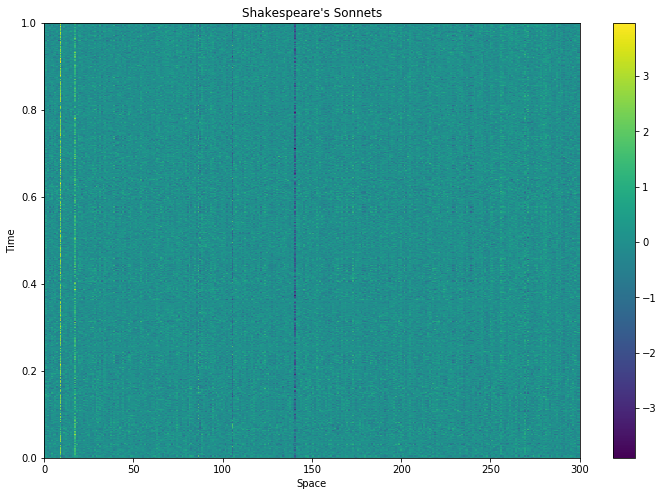

In [20]:
make_plot(X_sm,x=x,t=t_sm,title="Shakespeare's Sonnets", save=False)

In [21]:
#apply dynamic mode decomposition
dmd = DMD(svd_rank=0,opt=True)
dmd.fit(X_sm.T)
len(dmd.eigs)

71

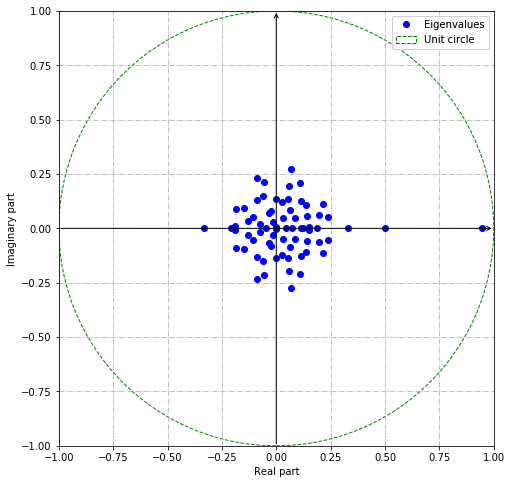

In [22]:
dmd.plot_eigs(show_axes=True, show_unit_circle=True)

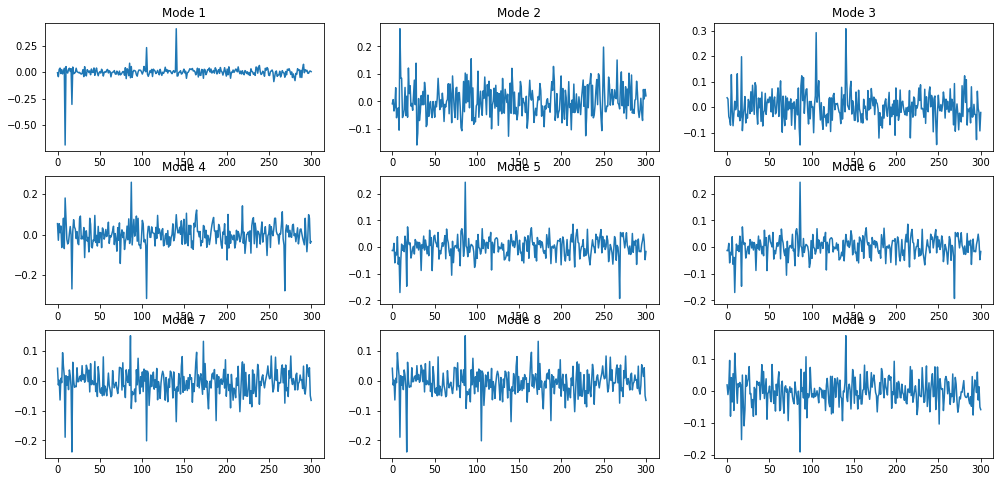

In [23]:
fig=plt.figure(figsize=(17,8))
for i, mode in zip(range(1,10),dmd.modes.T):
    plt.subplot(3,3,i)
    plt.plot(x, mode.real)
    plt.title('Mode ' + str(i))
plt.show()

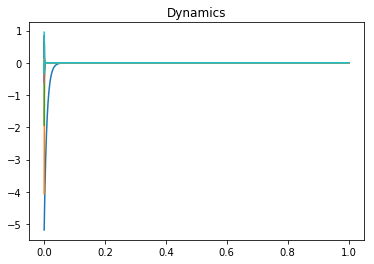

In [24]:
#DYNAMICS = 0: SOLVED - need to set opt=True so that when amplitudes (b) are calculated we minimize over the entire dataset
#and not just a single snapshot. Otherwise, b = 0 and the entire dynamics are zero.
for dynamic in dmd.dynamics[:10]:
    plt.plot(t_sm, dynamic.real)
    plt.title('Dynamics')
plt.show()

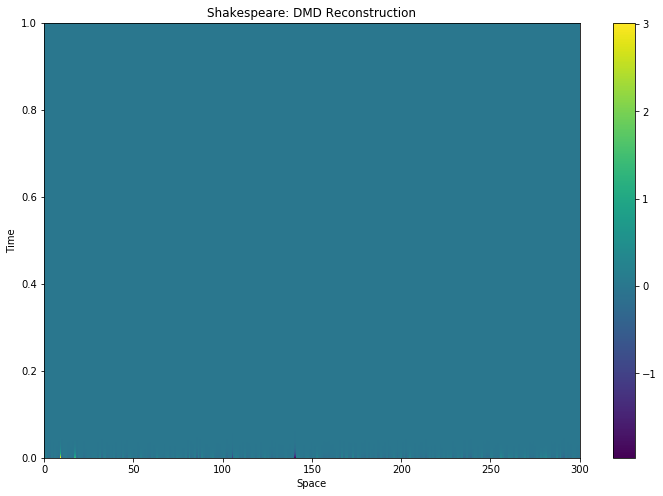

In [25]:
make_plot(X=dmd.reconstructed_data.T.real,x=x,t=t_sm,title='Shakespeare: DMD Reconstruction',save=True)

In [58]:
#try multi-resolution DMD
mrdmd = MrDMD(svd_rank=3, max_level=8, max_cycles=1, opt=False)
mrdmd.fit(X=X_sm.T)

In [59]:
mrdmd._steps

[250,
 125,
 125,
 62,
 62,
 62,
 62,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 4,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 1

The number of eigenvalues is 178


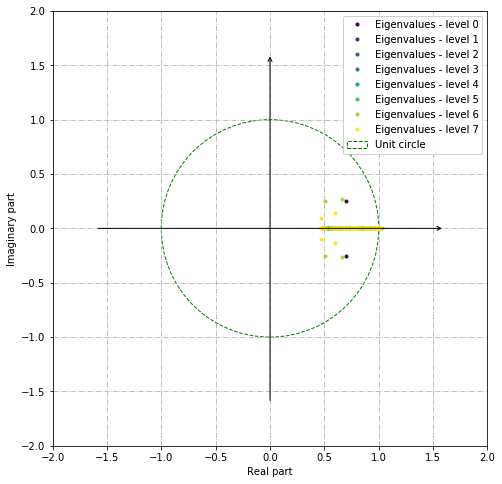

In [60]:
print('The number of eigenvalues is {}'.format(mrdmd.eigs.shape[0]))
mrdmd.plot_eigs(show_axes=True, show_unit_circle=True, figsize=(8, 8))

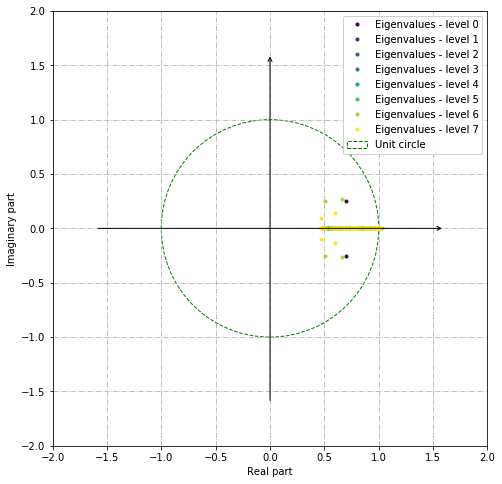

In [61]:
mrdmd.plot_eigs(show_axes=True, show_unit_circle=True, figsize=(8, 8), level=0, node=0)

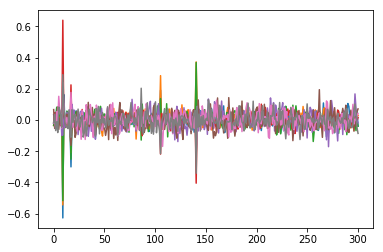

In [62]:
pmodes = mrdmd.partial_modes(level=3)
fig = plt.plot(x, pmodes.real)

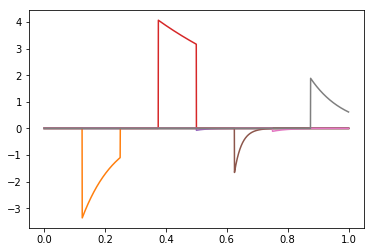

In [67]:
pdyna = mrdmd.partial_dynamics(level=3)
fig = plt.plot(t_sm, pdyna.real.T)

The number of modes in the level number 4 is 69


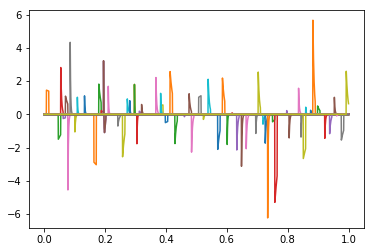

In [65]:
pdyna = mrdmd.partial_dynamics(level=7)
print('The number of modes in the level number 4 is {}'.format(pdyna.shape[0]))
fig = plt.plot(t_sm, pdyna.real.T)

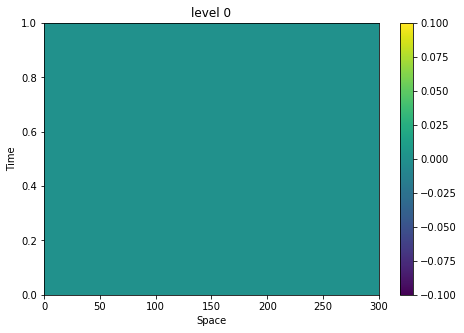

In [68]:
pdata = mrdmd.partial_reconstructed_data(level=0)
make_plot(pdata.T, x=x, t=t_sm, title='level 0', figsize=(7.5, 5))

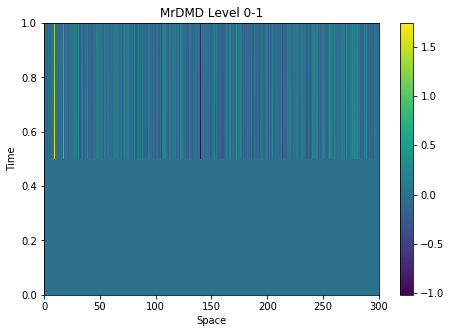

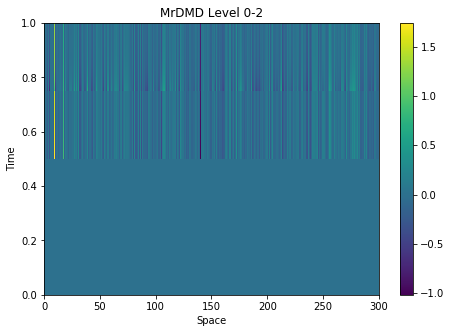

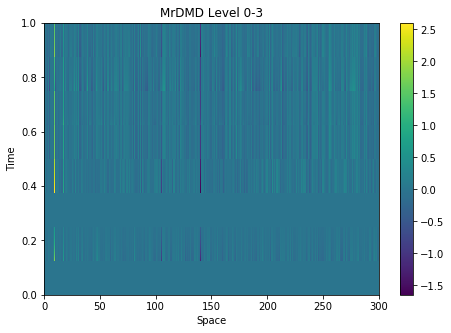

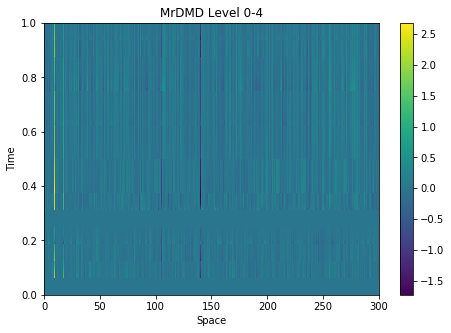

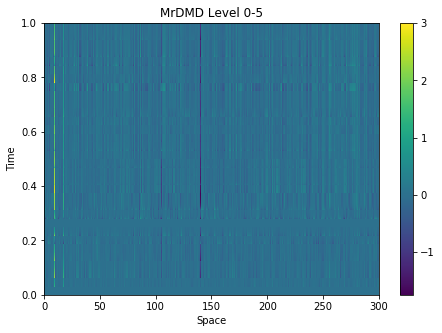

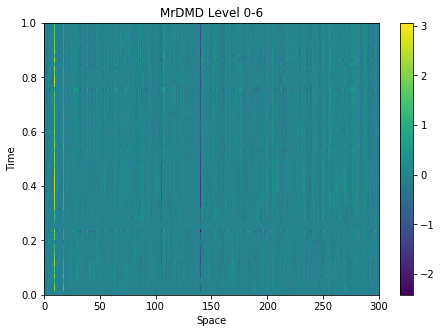

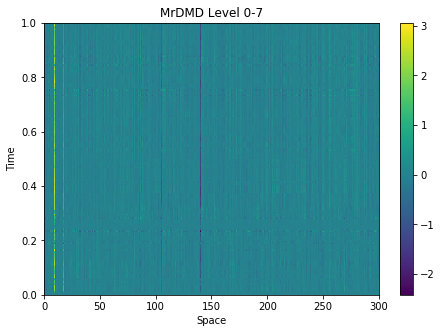

In [69]:
for i in range(1, 8):
    pdata += mrdmd.partial_reconstructed_data(level=i)
    make_plot(pdata.T, x=x, t=t_sm, title="MrDMD Level 0-" + str(i), figsize=(7.5, 5),save=True)

In [35]:
doc

﻿
Project Gutenberg’s The Complete Works of William Shakespeare, by William
Shakespeare

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever.  You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this eBook or online at
www.gutenberg.org.  If you are not located in the United States, you’ll
have to check the laws of the country where you are located before using
this ebook.

See at the end of this file: * CONTENT NOTE (added in 2017) *


Title: The Complete Works of William Shakespeare

Author: William Shakespeare

Release Date: January 1994 [EBook #100]
Last Updated: March 9, 2019

Language: English

Character set encoding: UTF-8

*** START OF THIS PROJECT GUTENBERG EBOOK THE COMPLETE WORKS OF WILLIAM SHAKESPEARE ***




The Complete Works of William Shakespeare



by William Shakespeare




      Contents



               THE SONN

In [36]:
#try spectrogram just from concatenated word vectors
X2=np.array([token.vector for token in doc])
X2=np.reshape(X2,(300*len(doc),))

In [37]:
X2.shape

(7009800,)

In [38]:
t_lg=np.linspace(0,1,len(X2))

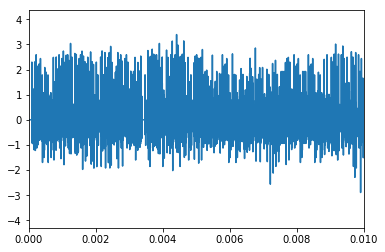

In [39]:
plt.plot(t_lg,X2)
plt.xlim(0,.01)
plt.show()

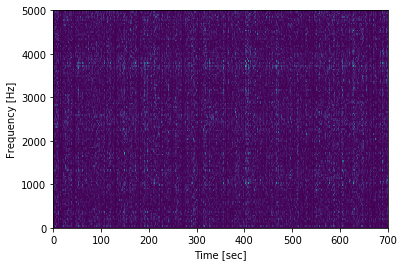

In [40]:
fs=10000
f, t, Sxx = signal.spectrogram(X2, fs)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [214]:
fourier=np.fft.rfft(X2)
len(fourier)

3504901

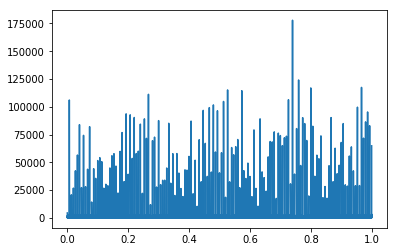

In [42]:
f_lg=np.linspace(0,1,len(fourier))
plt.plot(f_lg,np.abs(fourier))
plt.show()

In [172]:
#find words closest to vector
def sim(u,v):
    if np.linalg.norm(u) * np.linalg.norm(v) == 0: return float('nan')
    cos = np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v) )
    return cos.real

def most_similar(vec,vocab):
    if np.linalg.norm(vec) == 0: return vec
    queries = [v for v in vocab if not np.linalg.norm(v.vector)==0 and v.prob >= -15 and v.is_lower]
    by_sim = sorted(queries, key=lambda v: sim(vec,v.vector), reverse=True)
    return [w.orth_ for w in by_sim[:10]]

In [173]:
most_similar(nlp("dog").vector,doc.vocab)

['dog',
 'dogs',
 'puppy',
 'pet',
 'cat',
 'puppies',
 'canine',
 'pup',
 'cats',
 'terrier']

In [183]:
most_similar(pdata.T[100],doc.vocab)

['you', 'can', 'the', 'where', 'one', 'there', 'way', 'that', 'just', 'it']

In [206]:
[ most_similar(v,doc.vocab) for v in pdata.T[120:124] ]

[['be', 'not', 'or', 'are', 'either', 'as', 'there', 'well', 'can', 'must'],
 ['be', 'not', 'or', 'are', 'either', 'as', 'there', 'well', 'can', 'must'],
 ['be', 'not', 'or', 'are', 'either', 'there', 'as', 'well', 'can', 'must'],
 ['be', 'not', 'or', 'are', 'either', 'there', 'as', 'well', 'can', 'must']]

In [188]:
[word for word in doc[100:104]]

[laws, of, the, country]

In [189]:
sim(nlp('you').vector,nlp('laws').vector)

0.28911525

In [194]:
sim(pdata.T[100],nlp('laws').vector)

0.4292464275016354

In [196]:
doc_stripped = [token for token in doc if not token.is_space]

In [207]:
doc_stripped[120:124]

[Title, :, The, Complete]

In [204]:
most_similar(nlp("ebook").vector,doc.vocab)

['ebook',
 'ebooks',
 'books',
 'book',
 'kindle',
 'audiobook',
 'paperback',
 'pdf',
 'downloadable',
 'amazon']

In [213]:
sim(pdata.T[122],pdata.T[124])

0.9985090175622914